In [1]:
import pandas as pd

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from scipy.stats import pearsonr

In [3]:
from pandasql import sqldf
pysqldf = lambda q: sqldf(q,globals())

# Import data with Pandas

In [4]:
athlete_events = pd.read_csv("athlete_events.csv")
noc_regions    = pd.read_csv("noc_regions.csv")

# Look at the athlete database

In [5]:
athlete_events

,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal
0,1,A Dijiang,M,24.0,180.0,80.0,China,CHN,1992 Summer,1992,Summer,Barcelona,Basketball,Basketball Men's Basketball,NaN
1,2,A Lamusi,M,23.0,170.0,60.0,China,CHN,2012 Summer,2012,Summer,London,Judo,Judo Men's Extra-Lightweight,NaN
2,3,Gunnar Nielsen Aaby,M,24.0,NaN,NaN,Denmark,DEN,1920 Summer,1920,Summer,Antwerpen,Football,Football Men's Football,NaN
3,4,Edgar Lindenau Aabye,M,34.0,NaN,NaN,Denmark/Sweden,DEN,1900 Summer,1900,Summer,Paris,Tug-Of-War,Tug-Of-War Men's Tug-Of-War,Gold
4,5,Christine Jacoba Aaftink,F,21.0,185.0,82.0,Netherlands,NED,1988 Winter,1988,Winter,Calgary,Speed Skating,Speed Skating Women's 500 metres,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
271111,135569,Andrzej ya,M,29.0,179.0,89.0,Poland-1,POL,1976 Winter,1976,Winter,Innsbruck,Luge,Luge Mixed (Men)'s Doubles,NaN
271112,135570,Piotr ya,M,27.0,176.0,59.0,Poland,POL,2014 Winter,2014,Winter,Sochi,Ski Jumping,"Ski Jumping Men's Large Hill, Individual",NaN
271113,135570,Piotr ya,M,27.0,176.0,59.0,Poland,POL,2014 Winter,2014,Winter,Sochi,Ski Jumping,"Ski Jumping Men's Large Hill, Team",NaN
271114,135571,Tomasz Ireneusz ya,M,30.0,185.0,96.0,Poland,POL,1998 Winter,1998,Winter,Nagano,Bobsleigh,Bobsleigh Men's Four,NaN


In [6]:
athlete_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271116 entries, 0 to 271115
Data columns (total 15 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   ID      271116 non-null  int64  
 1   Name    271116 non-null  object 
 2   Sex     271116 non-null  object 
 3   Age     261642 non-null  float64
 4   Height  210945 non-null  float64
 5   Weight  208241 non-null  float64
 6   Team    271116 non-null  object 
 7   NOC     271116 non-null  object 
 8   Games   271116 non-null  object 
 9   Year    271116 non-null  int64  
 10  Season  271116 non-null  object 
 11  City    271116 non-null  object 
 12  Sport   271116 non-null  object 
 13  Event   271116 non-null  object 
 14  Medal   39783 non-null   object 
dtypes: float64(3), int64(2), object(10)
memory usage: 31.0+ MB


In [7]:
noc_regions

,NOC,region,notes
0,AFG,Afghanistan,NaN
1,AHO,Curacao,Netherlands Antilles
2,ALB,Albania,NaN
3,ALG,Algeria,NaN
4,AND,Andorra,NaN
...,...,...,...
225,YEM,Yemen,NaN
226,YMD,Yemen,South Yemen
227,YUG,Serbia,Yugoslavia
228,ZAM,Zambia,NaN


In [8]:
# Replace NOC regions with country name
pysqldf(
"""
SELECT  NOC,
        CASE WHEN notes is NOT NULL THEN notes
        ELSE region
        END
        AS Country
FROM noc_regions
AS noc_country
""")

,NOC,Country
0,AFG,Afghanistan
1,AHO,Netherlands Antilles
2,ALB,Albania
3,ALG,Algeria
4,AND,Andorra
...,...,...
225,YEM,Yemen
226,YMD,South Yemen
227,YUG,Yugoslavia
228,ZAM,Zambia


In [9]:
# Remove possible repeats and replace NOC code with country, and remove art competitions
athlete_events_filtered = pysqldf ("""
SELECT
    *
FROM
    athlete_events
    
LEFT JOIN
    (SELECT  NOC,
            CASE WHEN notes is NOT NULL THEN notes
            ELSE region
            END
            AS Country
    FROM noc_regions)
AS noc_country
    
ON noc_country.NOC = athlete_events.NOC

WHERE
    Sport <> "Art Competitions"
    AND
    Season = 'Summer'

GROUP BY
    ID,
    Games,
    Event,
    Medal
""")


Text(0, 0.5, 'Number of athletes')

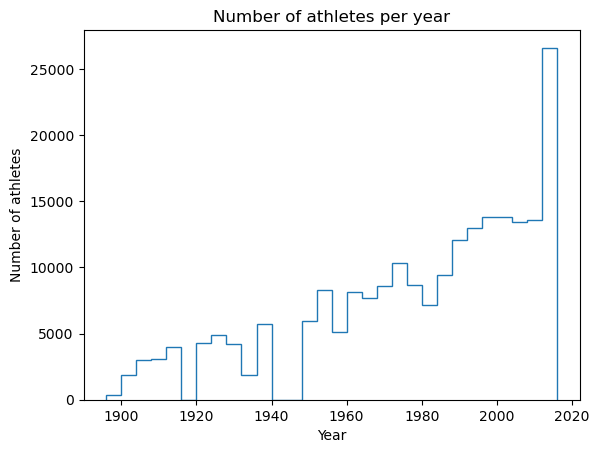

In [10]:
plt.hist(athlete_events_filtered['Year'], bins = 30, histtype = 'step')
plt.title('Number of athletes per year')
plt.xlabel('Year')
plt.ylabel('Number of athletes')

In [11]:
pysqldf("""
SELECT
    MIN (Year) AS earliest_year,
    MAX (Year) AS latest_year
FROM (
    SELECT
        *
    FROM
        athlete_events
    GROUP BY
        ID,
        Games,
        Event,
        Medal
    )
""")

,earliest_year,latest_year
0,1896,2016


(array([222552.,  48564.]),
 array([0. , 0.5, 1. ]),
 <BarContainer object of 2 artists>)

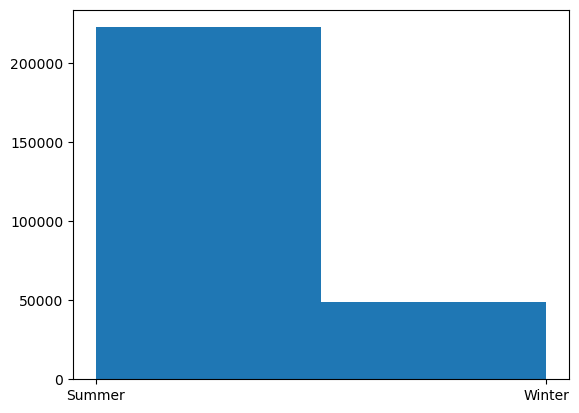

In [12]:
plt.hist(athlete_events['Season'], bins = 2)

** Distinct sports**

In [13]:
athletes_by_sport = pysqldf(
"""
SELECT
    Sport,
    COUNT(*) AS number_of_athletes
FROM
    athlete_events_filtered
GROUP BY
    Sport
ORDER BY COUNT(*) DESC
""")

print (athletes_by_sport.to_string())

                    Sport  number_of_athletes
0               Athletics               38624
1              Gymnastics               26707
2                Swimming               23195
3                Shooting               11448
4                 Cycling               10827
5                 Fencing               10735
6                  Rowing               10595
7               Wrestling                7154
8                Football                6745
9                 Sailing                6538
10          Equestrianism                6341
11               Canoeing                6171
12                 Boxing                6047
13                 Hockey                5417
14             Basketball                4536
15          Weightlifting                3937
16             Water Polo                3846
17                   Judo                3801
18               Handball                3665
19             Volleyball                3404
20                 Tennis         

In [14]:
athletes_by_sport_with_height = pysqldf(
"""
SELECT
    Sport,
    COUNT(*) AS number_of_athletes
FROM
    athlete_events_filtered
WHERE
    Height IS NOT NULL
GROUP BY
    Sport
ORDER BY COUNT(*) DESC
""")

print (athletes_by_sport_with_height.to_string())

                    Sport  number_of_athletes
0               Athletics               32907
1                Swimming               19150
2              Gymnastics               18662
3                 Cycling                7975
4                  Rowing                7920
5                Shooting                7669
6                 Fencing                6962
7                Canoeing                5560
8               Wrestling                5346
9                 Sailing                4939
10               Football                4647
11          Equestrianism                4602
12                 Boxing                4578
13                 Hockey                4315
14             Basketball                3881
15                   Judo                3400
16               Handball                3349
17             Volleyball                3283
18          Weightlifting                3008
19             Water Polo                2788
20                 Diving         

# Cleaning data:

We must remove:  
Repeated values  
Art competitions

We must create:  
2 subtables, one for male and one for female athletes  
We must be careful about the cleanliness of data. Some sports have a lot more athletes than others.

# Questions:

1. Which sports require taller/shorter athletes? Find average and standard deviation? Find average and standard deviation~.
2. Are there differences between medalists and non-medalists?
3. How has height changed for each sport?

# Hypotheses

1. There will be some differences
2. Height will become more specialized over time


# Answering questions
**1. Do some sports require taller athletes?**

In [15]:
# Look at height for all years.

athlete_events_by_height = pysqldf ("""
SELECT
    Sport,
    Sex,
    AVG(Height)                                   AS Height_mean,
    AVG(Height*Height) - AVG(Height)*AVG(Height)  AS Height_variance,  -- Variance = E(X^2) - (E(X))^2
    COUNT(*)                                      AS Number_of_athletes
FROM
    athlete_events_filtered
WHERE
    Height IS NOT NULL
GROUP BY
    Sport,
    Sex
ORDER BY
    Height_mean DESC
""")

# We calculate the standard deviation here because there's no inbuilt function in Pandasql
athlete_events_by_height['Height_stdev'] = np.sqrt(athlete_events_by_height['Height_variance'])
athlete_events_by_height = athlete_events_by_height.drop(columns = ['Height_variance'])
athlete_events_by_height

,Sport,Sex,Height_mean,Number_of_athletes,Height_stdev
0,Basketball,M,194.872624,2630,10.322597
1,Beach Volleyball,M,193.290909,275,6.011119
2,Volleyball,M,193.265660,1788,7.904945
3,Handball,M,188.778373,2053,7.345226
4,Rowing,M,186.882698,5797,9.234382
...,...,...,...,...,...
73,Wrestling,F,163.865132,304,6.913343
74,Trampolining,F,161.733333,75,4.803702
75,Diving,F,161.173604,985,5.986221
76,Weightlifting,F,160.467391,460,7.858049


In [16]:
pysqldf("""
SELECT
    *
FROM
    athlete_events_by_height
WHERE
    SEX = 'M'
""")

,Sport,Sex,Height_mean,Number_of_athletes,Height_stdev
0,Basketball,M,194.872624,2630,10.322597
1,Beach Volleyball,M,193.290909,275,6.011119
2,Volleyball,M,193.265660,1788,7.904945
3,Handball,M,188.778373,2053,7.345226
4,Rowing,M,186.882698,5797,9.234382
5,Water Polo,M,186.801739,2300,7.672242
6,Tennis,M,184.847806,1071,6.723580
7,Swimming,M,184.310928,10578,7.937863
8,Rugby Sevens,M,182.834437,151,7.301846
9,Baseball,M,182.599291,846,6.781211


In [17]:
pysqldf("""
SELECT
    *
FROM
    athlete_events_by_height
WHERE
    SEX = 'F'
""")

,Sport,Sex,Height_mean,Number_of_athletes,Height_stdev
0,Basketball,F,182.454836,1251,8.874838
1,Volleyball,F,179.494983,1495,7.876289
2,Beach Volleyball,F,178.866667,270,5.986157
3,Rowing,F,176.771079,2123,7.676108
4,Water Polo,F,175.563525,488,6.075352
5,Handball,F,174.840278,1296,6.333573
6,Tennis,F,172.335736,971,6.569485
7,Swimming,F,171.468735,8572,7.067046
8,Taekwondo,F,170.811644,292,7.190328
9,Modern Pentathlon,F,170.073171,164,6.056201


In [18]:
# Look at only the past 50 years

athlete_events_by_height_modern = pysqldf ("""
SELECT
    Sport,
    Sex,
    AVG(Height)                                   AS Height_mean,
    AVG(Height*Height) - AVG(Height)*AVG(Height)  AS Height_variance, -- Variance = E(X^2) - (E(X))^2
    COUNT(*)                                      AS Number_of_athletes
FROM
    athlete_events_filtered
WHERE
    Height IS NOT NULL
    AND 
    Year >= 1976
GROUP BY
    Sport,
    Sex
ORDER BY
    Height_mean DESC
""")

# We calculate the standard deviation here because there's no inbuilt function in Pandasql
athlete_events_by_height_modern['Height_stdev'] = np.sqrt(athlete_events_by_height_modern['Height_variance'])
athlete_events_by_height_modern = athlete_events_by_height_modern.drop(columns = ['Height_variance'])
athlete_events_by_height_modern

,Sport,Sex,Height_mean,Number_of_athletes,Height_stdev
0,Basketball,M,198.775367,1567,9.239524
1,Volleyball,M,195.018310,1420,7.344516
2,Beach Volleyball,M,193.290909,275,6.011119
3,Handball,M,189.354270,1815,7.337485
4,Water Polo,M,189.007658,1567,6.903099
...,...,...,...,...,...
63,Wrestling,F,163.865132,304,6.913343
64,Trampolining,F,161.733333,75,4.803702
65,Diving,F,161.278884,753,6.100469
66,Weightlifting,F,160.467391,460,7.858049


In [19]:
athlete_events_by_height_modern_male = pysqldf("""
SELECT
    *
FROM
    athlete_events_by_height_modern
WHERE
    SEX = 'M'
""")

athlete_events_by_height_modern_male

,Sport,Sex,Height_mean,Number_of_athletes,Height_stdev
0,Basketball,M,198.775367,1567,9.239524
1,Volleyball,M,195.018310,1420,7.344516
2,Beach Volleyball,M,193.290909,275,6.011119
3,Handball,M,189.354270,1815,7.337485
4,Water Polo,M,189.007658,1567,6.903099
5,Rowing,M,188.809228,3858,8.721300
6,Swimming,M,185.719038,8026,7.593699
7,Tennis,M,185.064202,1028,6.592190
8,Rugby Sevens,M,182.834437,151,7.301846
9,Baseball,M,182.599291,846,6.781211


In [20]:
print ('Minimum standard deviation: ', min(athlete_events_by_height_modern_male.Height_stdev))
print ('Maximum standard deviation: ', max(athlete_events_by_height_modern_male.Height_stdev))

Minimum standard deviation:  5.2568388340926875
Maximum standard deviation:  10.160997002651495


In [21]:
athlete_events_by_height_modern_female = pysqldf("""
SELECT
    *
FROM
    athlete_events_by_height_modern
WHERE
    SEX = 'F'
""")

athlete_events_by_height_modern_female

,Sport,Sex,Height_mean,Number_of_athletes,Height_stdev
0,Basketball,F,182.454836,1251,8.874838
1,Volleyball,F,180.867200,1250,7.568353
2,Beach Volleyball,F,178.866667,270,5.986157
3,Rowing,F,176.771079,2123,7.676108
4,Water Polo,F,175.563525,488,6.075352
5,Handball,F,174.840278,1296,6.333573
6,Swimming,F,172.506431,6842,6.935206
7,Tennis,F,172.412863,964,6.508188
8,Taekwondo,F,170.811644,292,7.190328
9,Canoeing,F,170.124664,1115,5.562823


In [22]:
print ('Minimum standard deviation: ', min(athlete_events_by_height_modern_female.Height_stdev))
print ('Maximum standard deviation: ', max(athlete_events_by_height_modern_female.Height_stdev))

Minimum standard deviation:  4.803702275907493
Maximum standard deviation:  8.874837936233474


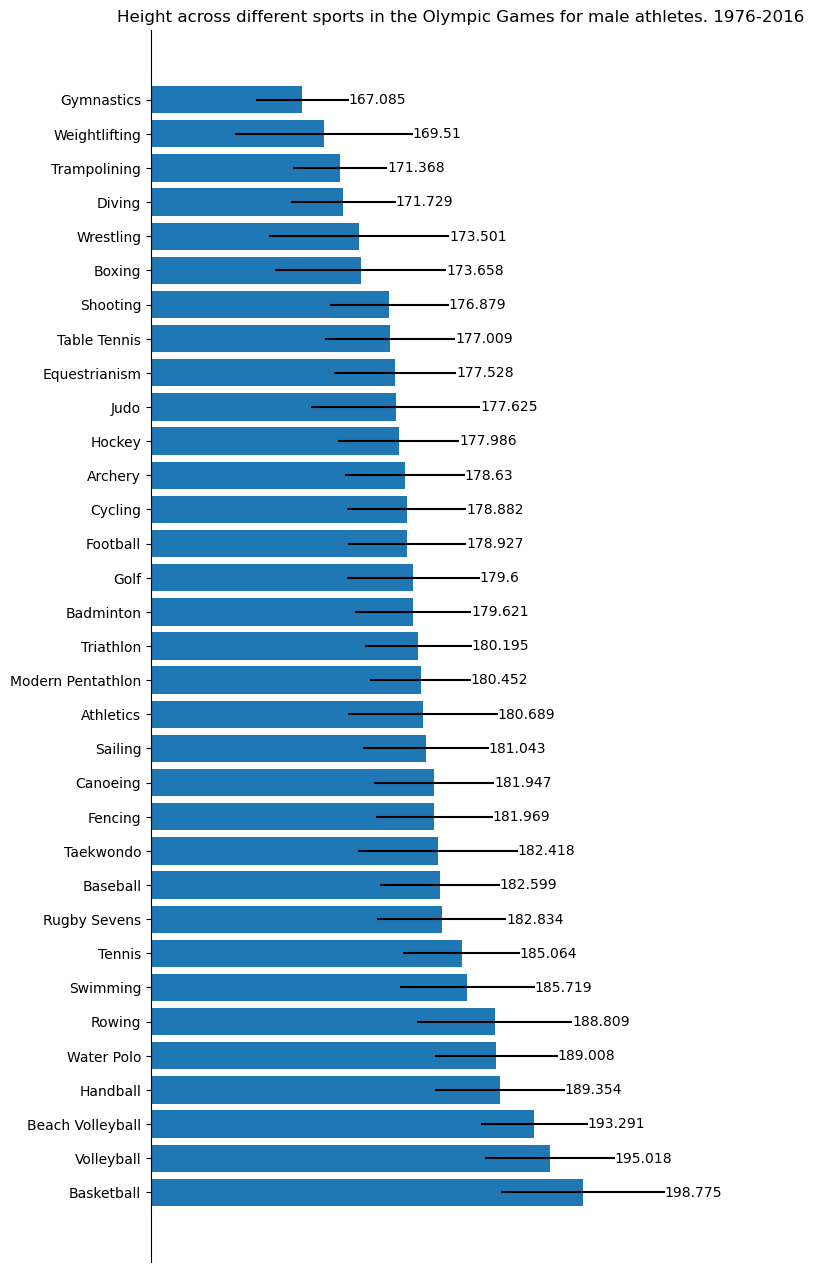

In [23]:
fig, ax = plt.subplots(figsize=(8,16))

bars = plt.barh(athlete_events_by_height_modern_male['Sport'], athlete_events_by_height_modern_male['Height_mean'], xerr = athlete_events_by_height_modern_male['Height_stdev'])
plt.xlabel('Height(cm)')

ax.spines[['right', 'top', 'bottom']].set_visible(False) 
ax.xaxis.set_visible(False)

ax.bar_label(bars)

plt.xlim(150,220)
plt.title ('Height across different sports in the Olympic Games for male athletes. 1976-2016')
plt.show()

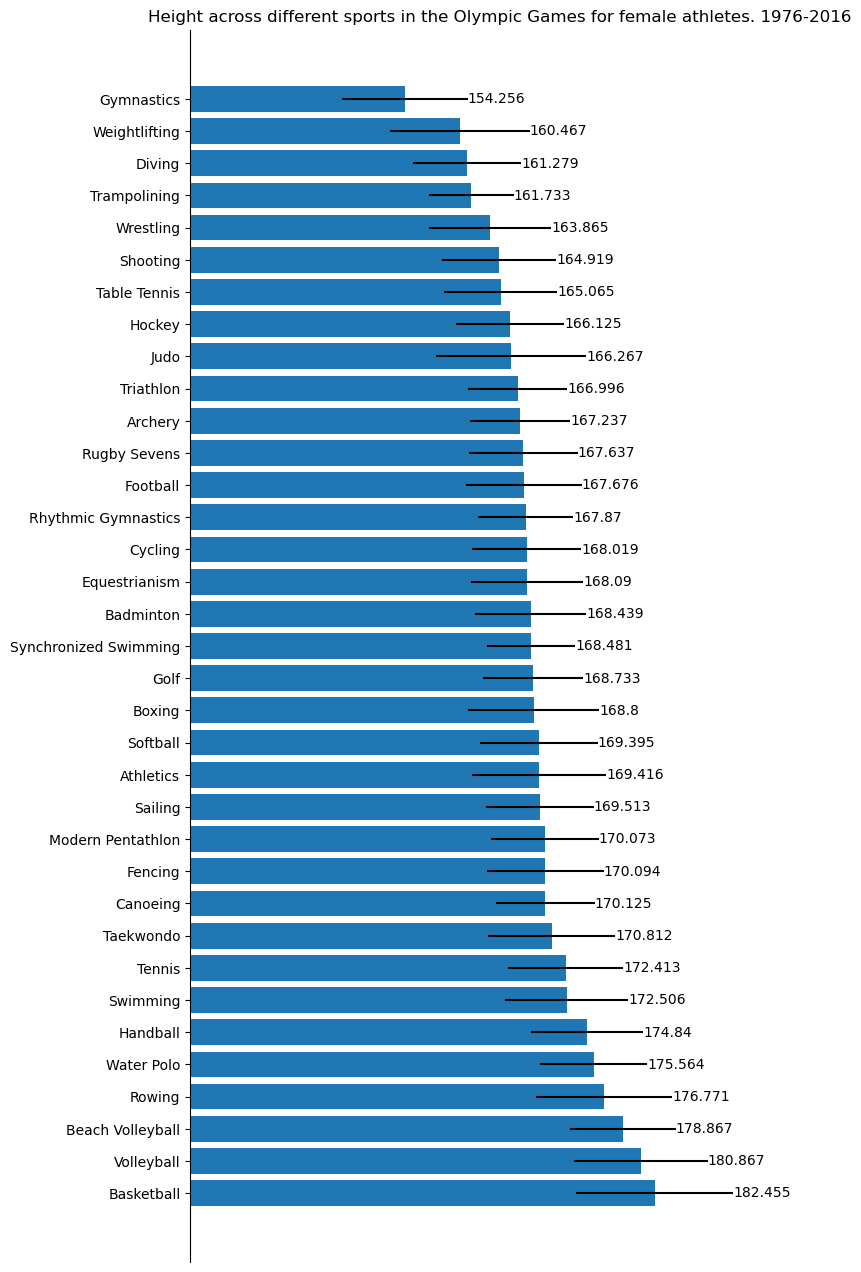

In [24]:
fig, ax = plt.subplots(figsize=(8,16))

bars = plt.barh(athlete_events_by_height_modern_female['Sport'], athlete_events_by_height_modern_female['Height_mean'], xerr = athlete_events_by_height_modern_female['Height_stdev'])
plt.xlabel('Height(cm)')

ax.spines[['right', 'top', 'bottom']].set_visible(False) 
ax.xaxis.set_visible(False)

ax.bar_label(bars)

plt.xlim(130,200)
plt.title ('Height across different sports in the Olympic Games for female athletes. 1976-2016')
plt.show()

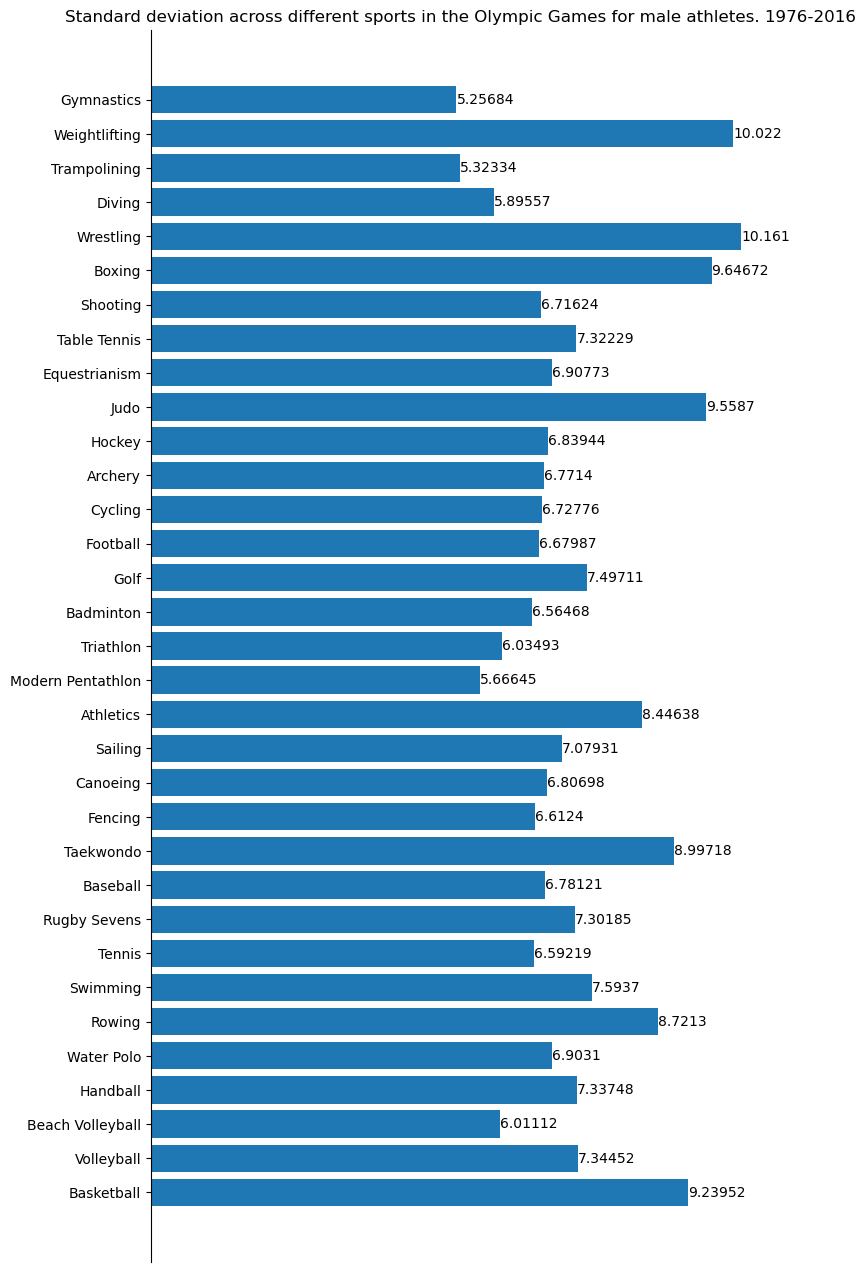

In [25]:
fig, ax = plt.subplots(figsize=(8,16))

bars = plt.barh(athlete_events_by_height_modern_male['Sport'], athlete_events_by_height_modern_male['Height_stdev'])
plt.xlabel('Height(cm)')

ax.spines[['right', 'top', 'bottom']].set_visible(False) 
ax.xaxis.set_visible(False)

ax.bar_label(bars)

plt.title ('Standard deviation across different sports in the Olympic Games for male athletes. 1976-2016')
plt.show()

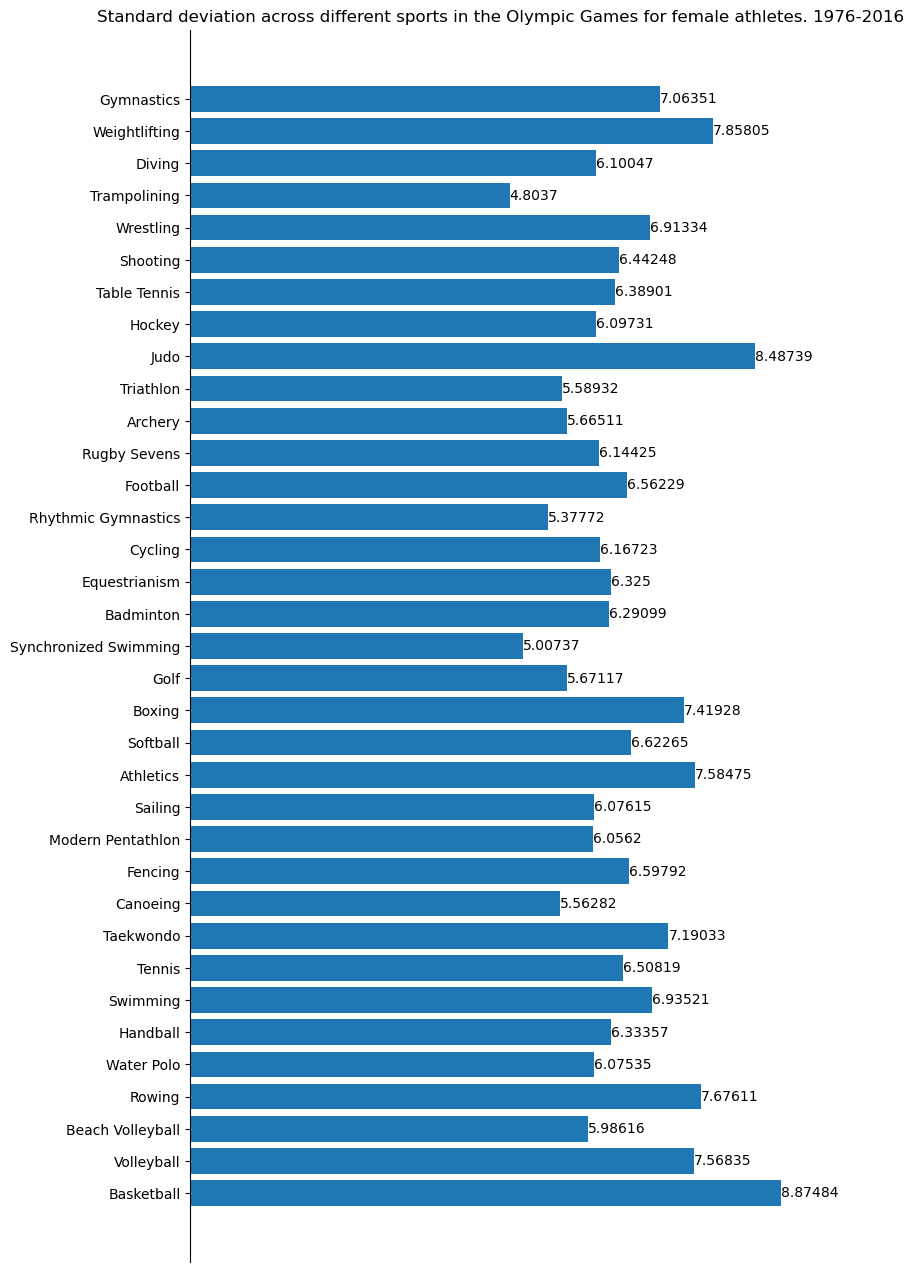

In [26]:
fig, ax = plt.subplots(figsize=(8,16))

bars = plt.barh(athlete_events_by_height_modern_female['Sport'], athlete_events_by_height_modern_female['Height_stdev'])
plt.xlabel('Height(cm)')

ax.spines[['right', 'top', 'bottom']].set_visible(False) 
ax.xaxis.set_visible(False)

ax.bar_label(bars)

plt.title ('Standard deviation across different sports in the Olympic Games for female athletes. 1976-2016')
plt.show()

In [27]:
athlete_events_height_evolution = pysqldf ("""
SELECT
    Sport,
    Sex,
    Year,
    AVG(Height)                                   AS Height_mean,
    AVG(Height*Height) - AVG(Height)*AVG(Height)  AS Height_variance,  -- Variance = E(X^2) - (E(X))^2
    COUNT(*)                                      AS Number_of_athletes
FROM
    athlete_events_filtered
WHERE
    Height IS NOT NULL
GROUP BY
    Sport,
    Sex,
    Year
ORDER BY
    Height_mean DESC
""")




# We calculate the standard deviation here because there's no inbuilt function in Pandasql
athlete_events_height_evolution['Height_stdev'] = np.sqrt(athlete_events_height_evolution['Height_variance'])
athlete_events_height_evolution = athlete_events_height_evolution.drop(columns = ['Height_variance'])
athlete_events_height_evolution

,Sport,Sex,Year,Height_mean,Number_of_athletes,Height_stdev
0,Basketball,M,2012,200.638889,144,8.356311
1,Basketball,M,2016,200.503546,141,8.416991
2,Basketball,M,2004,200.111111,144,8.938922
3,Basketball,M,2008,200.076389,144,9.576505
4,Basketball,M,1992,199.539007,141,9.449018
...,...,...,...,...,...,...
953,Diving,F,1924,153.500000,6,5.678908
954,Diving,F,1928,153.500000,2,1.500000
955,Gymnastics,F,2000,153.219959,491,6.496160
956,Gymnastics,F,1980,152.553073,358,8.487995


In [28]:
athlete_events_height_evolution_male = pysqldf("""
SELECT
    *
FROM
    athlete_events_height_evolution
WHERE
    SEX = 'M'
""")

athlete_events_height_evolution_male

,Sport,Sex,Year,Height_mean,Number_of_athletes,Height_stdev
0,Basketball,M,2012,200.638889,144,8.356311
1,Basketball,M,2016,200.503546,141,8.416991
2,Basketball,M,2004,200.111111,144,8.938922
3,Basketball,M,2008,200.076389,144,9.576505
4,Basketball,M,1992,199.539007,141,9.449018
...,...,...,...,...,...,...
604,Diving,M,1920,166.500000,10,4.801042
605,Gymnastics,M,1984,166.455535,551,5.396554
606,Gymnastics,M,1996,166.363901,687,4.661625
607,Equestrianism,M,1900,166.000000,2,0.000000


In [29]:
athlete_events_height_evolution_female = pysqldf("""
SELECT
    *
FROM
    athlete_events_height_evolution
WHERE
    SEX = 'F'
""")

athlete_events_height_evolution_female

,Sport,Sex,Year,Height_mean,Number_of_athletes,Height_stdev
0,Basketball,F,2012,184.006993,143,8.550546
1,Volleyball,F,2016,183.816901,142,7.963490
2,Basketball,F,2016,183.300000,140,9.146194
3,Basketball,F,2008,183.293706,143,8.603815
4,Volleyball,F,2008,183.264286,140,8.289073
...,...,...,...,...,...,...
344,Diving,F,1924,153.500000,6,5.678908
345,Diving,F,1928,153.500000,2,1.500000
346,Gymnastics,F,2000,153.219959,491,6.496160
347,Gymnastics,F,1980,152.553073,358,8.487995


In [30]:
average_height_evolution_male = pysqldf("""
SELECT
    Year, AVG(Height_mean) AS Height_mean, SUM(Number_of_athletes) AS Number_of_athletes
FROM
    athlete_events_height_evolution
WHERE
    SEX = 'M'
GROUP BY
    Year
""")

average_height_evolution_male

,Year,Height_mean,Number_of_athletes
0,1896,172.454861,46
1,1900,175.034357,116
2,1904,175.834894,213
3,1906,176.592465,257
4,1908,178.192525,474
5,1912,176.525315,721
6,1920,174.240559,746
7,1924,175.552394,846
8,1928,174.359370,777
9,1932,173.211839,874


In [31]:
average_height_evolution_female = pysqldf("""
SELECT
    Year, AVG(Height_mean) AS Height_mean, SUM(Number_of_athletes) AS Number_of_athletes
FROM
    athlete_events_height_evolution
WHERE
    SEX = 'F'
GROUP BY
    Year
""")

average_height_evolution_female

,Year,Height_mean,Number_of_athletes
0,1920,160.869318,21
1,1924,162.141667,30
2,1928,165.245126,72
3,1932,166.220430,101
4,1936,167.450321,99
5,1948,166.663272,127
6,1952,164.980838,403
7,1956,165.607228,476
8,1960,165.183664,1381
9,1964,165.447514,1327


In [32]:
def split_initial(df, n_groups, colname="a"):
    df_sub = []
    for i in range(1, n_groups + 1):
        df_sub.append(df[df[colname] == i])
    return df_sub

n_counts = athlete_events_height_evolution_male['Sport'].nunique()
a = split_initial (athlete_events_height_evolution_male, n_counts, colname = 'Sport')

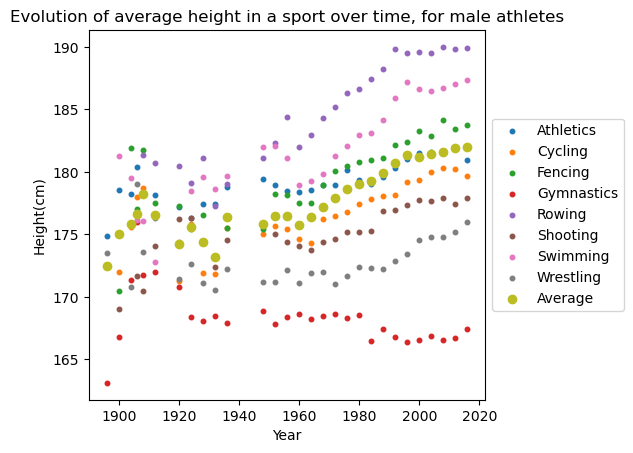

In [54]:
sport_average_height_evolution_male = list(athlete_events_height_evolution_male.groupby("Sport"))
for i in sport_average_height_evolution_male:
    i = pd.DataFrame(i[1])
 

fig = plt.figure()
ax = plt.subplot(111)


for i in sport_average_height_evolution_male:
    if i[1]['Number_of_athletes'].sum() >= 5000:
        ax.scatter (i[1].Year, i[1].Height_mean, s = 10.5, label = i[0])

        

plt.title('Evolution of average height in a sport over time, for male athletes')

plt.scatter (average_height_evolution_male['Year'], average_height_evolution_male['Height_mean'], label = 'Average')
plt.xlabel('Year')
plt.ylabel('Height(cm)')

# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

Athletics  r =  0.7793086302202045 , (p = 6.321147419523641e-07 )
Cycling  r =  0.6914937847387248 , (p = 6.484323534300817e-05 )
Fencing  r =  0.7195881851725947 , (p = 1.59072026885595e-05 )
Gymnastics  r =  -0.45871062146708785 , (p = 0.012321456391873027 )
Rowing  r =  0.9300295278146614 , (p = 1.7607243697746023e-11 )
Shooting  r =  0.7990627303300043 , (p = 9.83983506686635e-07 )
Swimming  r =  0.866278704594997 , (p = 2.5757221355772802e-09 )
Wrestling  r =  0.1242233656571102 , (p = 0.5288214004626797 )
Average   r =  0.8597270889940113  (p = 2.314428318069059e-09 )


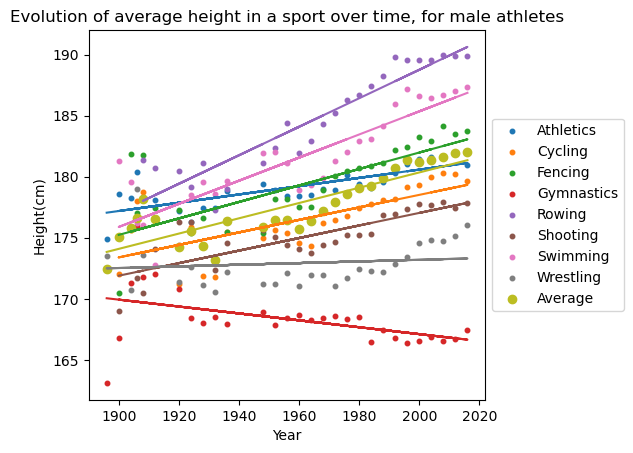

In [52]:
sport_average_height_evolution_male = list(athlete_events_height_evolution_male.groupby("Sport"))
for i in sport_average_height_evolution_male:
    i = pd.DataFrame(i[1])
 

fig = plt.figure()
ax = plt.subplot(111)


for i in sport_average_height_evolution_male:
    if i[1]['Number_of_athletes'].sum() >= 5000:
        ax.scatter (i[1].Year, i[1].Height_mean, s = 10.5, label = i[0])
        
        # Calculate equation for trendline
        x = i[1].Year
        y = i[1].Height_mean
        z = np.polyfit(x, y, 1)
        p = np.poly1d(z)
        ax.plot (x, p(x))
        
        # Calculate r
        
        r = pearsonr (x,y)
        print (i[0],  ' r = ', r[0], ', (p =', r[1],')')
        


plt.scatter (average_height_evolution_male['Year'], average_height_evolution_male['Height_mean'], label = 'Average')

x = average_height_evolution_male['Year']
y = average_height_evolution_male['Height_mean']
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
ax.plot (x, p(x))
r = pearsonr(x,y)
print ('Average   r = ', r[0], ' (p =', r[1],')')

        
plt.xlabel('Year')
plt.ylabel('Height(cm)')
plt.title('Evolution of average height in a sport over time, for male athletes')

# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

##### sport_average_height_evolution_female = list(athlete_events_height_evolution_female.groupby("Sport"))
for i in sport_average_height_evolution_female:
    i = pd.DataFrame(i[1])
 

fig = plt.figure()
ax = plt.subplot(111)


for i in sport_average_height_evolution_female:
    if i[1]['Number_of_athletes'].sum() >= 5000:
        ax.scatter (i[1].Year, i[1].Height_mean, s = 10.5, label = i[0])
        
        # Calculate equation for trendline
        x = i[1].Year
        y = i[1].Height_mean
        z = np.polyfit(x, y, 1)
        p = np.poly1d(z)
        ax.plot (x, p(x))
        
        # Calculate r
        
        r = pearsonr (x,y)
        print (i[0],  ' r = ', r[0], ', (p =', r[1],')')
        


plt.scatter (average_height_evolution_female['Year'], average_height_evolution_female['Height_mean'], label = 'Average')

x = average_height_evolution_female['Year']
y = average_height_evolution_female['Height_mean']
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
ax.plot (x, p(x))
r = pearsonr(x,y)
print ('Average   r = ', r[0], ' (p =', r[1],')')

        
plt.xlabel('Year')
plt.ylabel('Height(cm)')
plt.title('Evolution of average height in a sport over time, for female athletes')

# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [36]:
i = sport_average_height_evolution_male[0][1]
i.Height_mean

213    179.847619
216    179.790000
219    179.686869
233    179.466019
237    179.300000
255    178.894231
259    178.804598
328    177.408163
331    177.324324
339    177.000000
387    175.894737
446    174.297297
559    169.875000
Name: Height_mean, dtype: float64

In [47]:
height_deviation_from_mean_male = []
for i in range (len(sport_average_height_evolution_male)):
    sport_average = sport_average_height_evolution_male[i][1]
    sport_name    = sport_average_height_evolution_male[i][0]
    
    query = pysqldf("""
    SELECT
        average_height_evolution_male.Year,
        sport_average.Height_mean - average_height_evolution_male.Height_mean AS Deviation,
        sport_average.Number_of_athletes
    FROM
        average_height_evolution_male
    LEFT JOIN
        sport_average
    ON
        sport_average.Year = average_height_evolution_male.Year
    WHERE
        average_height_evolution_male.Year IS NOT NULL
    """)
    height_deviation_from_mean_male.append((sport_name,query))

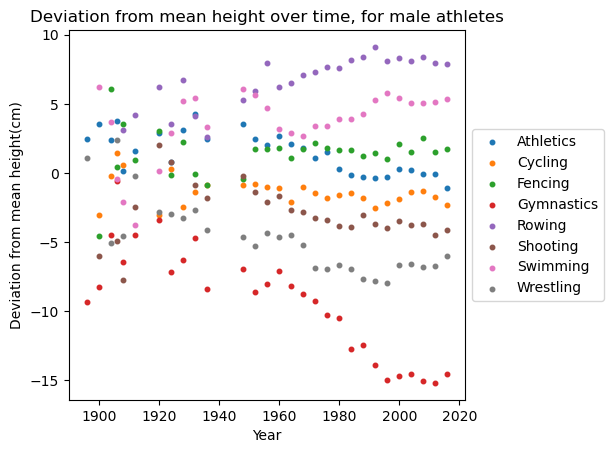

In [40]:
fig = plt.figure()
ax = plt.subplot(111)


for i in height_deviation_from_mean_male:
        if i[1]['Number_of_athletes'].sum() >= 5000:
            plt.scatter (i[1].Year, i[1].Deviation, s = 10.5, label = i[0])
            
plt.xlabel('Year')
plt.ylabel('Deviation from mean height(cm)')
plt.title('Deviation from mean height over time, for male athletes')

# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [45]:
ind = np.arange(len(athlete_events_by_height_medal_male['Sport']))
width = 0.4

fig, ax = plt.subplots(figsize=(8,16))
bars = plt.barh(ind, athlete_events_by_height_medal_male['Height_mean_medal'], xerr = athlete_events_by_height_medal_male['Height_stdev_medal'], label = 'Medal', height = 0.4)
plt.xlabel('Height(cm)')



bars2 = plt.barh(ind + width, athlete_events_by_height_medal_male['Height_mean_no_medal'], xerr = athlete_events_by_height_medal_male['Height_stdev_no_medal'], label = 'Without Medal', height = 0.4)

#ax.spines[['right', 'top', 'bottom']].set_visible(False) 
#ax.xaxis.set_visible(False)

#ax.bar_label(bars)

plt.legend()
plt.xlim(140,220)
ax.set(yticks=ind + 0.5 * width, yticklabels=athlete_events_by_height_medal_male['Sport'], ylim=[2*width - 1, len(athlete_events_by_height_medal_male['Sport'])])

plt.title ('Height across different sports in the Olympic Games for male athletes. 1976-2016')
plt.show()

NameError: name 'athlete_events_by_height_medal_male' is not defined

# Question 2.

In [ ]:
# Look at height for all years.

athlete_events_by_height_with_medal = pysqldf ("""
SELECT
    Sport,
    Sex,
    AVG(Height)                                   AS Height_mean,
    AVG(Height*Height) - AVG(Height)*AVG(Height)  AS Height_variance  -- Variance = E(X^2) - (E(X))^2
FROM
    athlete_events_filtered
WHERE
    Height IS NOT NULL
    AND
    Medal IS NOT NULL
GROUP BY
    Sport,
    Sex
ORDER BY
    Height_mean DESC
""")

# We calculate the standard deviation here because there's no inbuilt function in Pandasql
athlete_events_by_height_with_medal['Height_stdev'] = np.sqrt(athlete_events_by_height_with_medal['Height_variance'])
athlete_events_by_height_with_medal = athlete_events_by_height_with_medal.drop(columns = ['Height_variance'])
athlete_events_by_height_with_medal

In [ ]:
athlete_events_by_height_without_medal = pysqldf ("""
SELECT
    Sport,
    Sex,
    COUNT(*)                                      AS Number_of_athletes,
    AVG(Height)                                   AS Height_mean,
    AVG(Height*Height) - AVG(Height)*AVG(Height)  AS Height_variance  -- Variance = E(X^2) - (E(X))^2
FROM
    athlete_events_filtered
WHERE
    Height IS NOT NULL
    AND
    Medal IS NULL
GROUP BY
    Sport,
    Sex
ORDER BY
    Height_mean DESC
""")

# We calculate the standard deviation here because there's no inbuilt function in Pandasql
athlete_events_by_height_without_medal['Height_stdev'] = np.sqrt(athlete_events_by_height_without_medal['Height_variance'])
athlete_events_by_height_without_medal = athlete_events_by_height_without_medal.drop(columns = ['Height_variance'])
athlete_events_by_height_without_medal

In [ ]:
athlete_events_by_height_medal = pysqldf("""
SELECT
    athlete_events_by_height_with_medal.SPORT,
    athlete_events_by_height_with_medal.SEX,
    athlete_events_by_height_with_medal.Height_mean     AS Height_mean_medal,
    athlete_events_by_height_with_medal.Height_stdev    AS Height_stdev_medal,
    athlete_events_by_height_without_medal.Height_mean  AS Height_mean_no_medal,
    athlete_events_by_height_without_medal.Height_stdev AS Height_stdev_no_medal
FROM 
    athlete_events_by_height_with_medal
INNER JOIN
    athlete_events_by_height_without_medal
ON
    athlete_events_by_height_with_medal.Sex = athlete_events_by_height_without_medal.Sex
    AND
    athlete_events_by_height_with_medal.Sport = athlete_events_by_height_without_medal.Sport
""")

In [ ]:
athlete_events_by_height_medal

In [ ]:
athlete_events_by_height_medal_male = pysqldf("""
SELECT
    *
FROM
    athlete_events_by_height_medal
WHERE
    SEX = 'M'
""")

athlete_events_by_height_medal_male

In [ ]:
athlete_events_by_height_medal_female = pysqldf("""
SELECT
    *
FROM
    athlete_events_by_height_medal
WHERE
    SEX = 'F'
""")

athlete_events_by_height_medal_female

In [ ]:
ind = np.arange(len(athlete_events_by_height_medal_male['Sport']))
width = 0.4

fig, ax = plt.subplots(figsize=(8,16))
bars = plt.barh(ind, athlete_events_by_height_medal_male['Height_mean_medal'], xerr = athlete_events_by_height_medal_male['Height_stdev_medal'], label = 'Medal', height = 0.4)
plt.xlabel('Height(cm)')



bars2 = plt.barh(ind + width, athlete_events_by_height_medal_male['Height_mean_no_medal'], xerr = athlete_events_by_height_medal_male['Height_stdev_no_medal'], label = 'Without Medal', height = 0.4)

#ax.spines[['right', 'top', 'bottom']].set_visible(False) 
#ax.xaxis.set_visible(False)

#ax.bar_label(bars)

plt.legend()
plt.xlim(140,220)
ax.set(yticks=ind + 0.5 * width, yticklabels=athlete_events_by_height_medal_male['Sport'], ylim=[2*width - 1, len(athlete_events_by_height_medal_male['Sport'])])

plt.title ('Height across different sports in the Olympic Games for male athletes. 1976-2016')
plt.show()

In [ ]:
len(athlete_events_by_height_with_medal.Sport)

In [44]:
ind = np.arange(len(athlete_events_by_height_medal_female['Sport']))
width = 0.4

fig, ax = plt.subplots(figsize=(8,16))
bars = plt.barh(ind, athlete_events_by_height_medal_female['Height_mean_medal'], xerr = athlete_events_by_height_medal_female['Height_stdev_medal'], label = 'Medal', height = 0.4)
plt.xlabel('Height(cm)')



bars2 = plt.barh(ind + width, athlete_events_by_height_medal_female['Height_mean_no_medal'], xerr = athlete_events_by_height_medal_female['Height_stdev_no_medal'], label = 'Without Medal', height = 0.4)

#ax.spines[['right', 'top', 'bottom']].set_visible(False) 
#ax.xaxis.set_visible(False)

#ax.bar_label(bars)

plt.legend()
plt.xlim(140,220)
ax.set(yticks=ind + 0.5 * width, yticklabels=athlete_events_by_height_medal_female['Sport'], ylim=[2*width - 1, len(athlete_events_by_height_medal_female['Sport'])])

plt.title ('Height across different sports in the Olympic Games for female athletes. 1976-2016')
plt.show()

NameError: name 'athlete_events_by_height_medal_female' is not defined

In [ ]:
ind

In [ ]:
athlete_events_height_ratio = pysqldf ("""
SELECT
    male.Sport, male.Height_mean/female.Height_mean AS `Male to Female Height Ratio`
FROM
    athlete_events_by_height_modern_male   AS male
INNER JOIN
    athlete_events_by_height_modern_female AS female
ON
    male.Sport = female.Sport
""")

In [ ]:
fig, ax = plt.subplots(figsize=(8,16))

bars = plt.barh(athlete_events_height_ratio['Sport'], athlete_events_height_ratio['Male to Female Height Ratio'])
plt.xlabel('Height(cm)')

ax.spines[['right', 'top']].set_visible(False)
ax.bar_label(bars)
plt.xlim((1, 1.1))

plt.title ('Ratio between average male and female height for Olympic athletes. 1976-2016')
plt.show()

In [ ]:
plt.scatter(athlete_events_by_height_modern_male.Height_mean, athlete_events_by_height_modern_male.Height_stdev, s = 5)
plt.xlabel('Height (cm)')
plt.ylabel('Height standard deviation (cm)')
plt.title ('Scatter plot of the height standard deviation as a function of height for male athletes')

pearsonr(athlete_events_by_height_modern_male.Height_mean, athlete_events_by_height_modern_male.Height_stdev)